# [E-03] Camera Sticker Application
- dlib의 face detection을 사용해 이미지의 얼굴을 검출한다.
- objeck keypoint extimation을 이용해 face landmark localization을 한다. 
    - 이는 face detection의 결과물인 bounding box로 얼굴을 잘라내 사용한다. 
- landmark를 이용해 스티커를 붙일 위치 좌표를 계산한다. 


## 1) load image
- load image
- change bgr to rgb

In [159]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print('import complete !')

import complete !


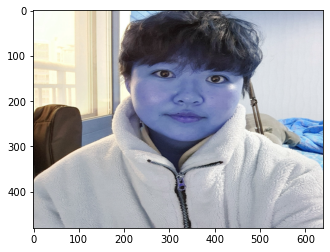

In [203]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/me.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

- opencv는 이미지를 BGR로 처리하기 때문에 RGB로 변환한다.

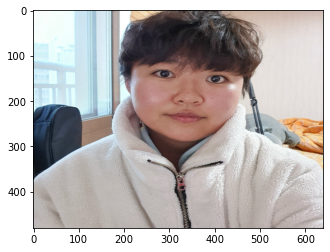

In [204]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2) face detection
- dlib의 face detector사용 

In [205]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print('import complete !')

import complete !


In [206]:
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)  # 검출한 얼굴 영역 좌표

rectangles[[(216, 68) (439, 291)]]


In [207]:
print(dlib_rects[0].left())
print(dlib_rects[0].top())
print(dlib_rects[0].right())
print(dlib_rects[0].bottom())

216
68
439
291


- 코드 참고   
cv2.rectangle(img, (start point), (end point), line's color, line's thickness, linetype)

216 68
439 291


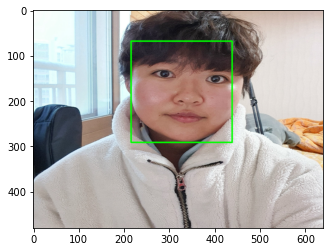

In [208]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    print(l,t)
    print(r,b)

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3) landmark localization
- dlib에서 제공되는 모델의 weight file을 사용한다.
- 위에서 자른 이미지에서 68개의 이목구비 위치를 찾는다.

In [209]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print('load model complete !')

load model complete !


In [210]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))   # 68개 이목구비 갯수 확인

68


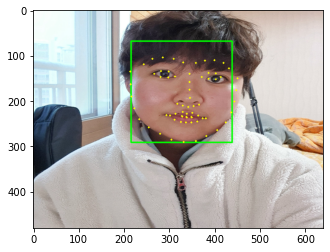

In [211]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4) 스티커의 위치좌표 설정하기
- 고양이 수염 스티커이기 때문에 볼의 좌표를 찾는다.
- 좌표는 랜드마크 좌표로 사용한다.

In [212]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[2]) # nose center index : 30
    x = landmark[2][0]
    y = landmark[2][1] #+ dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(217, 190)
(x,y) : (217,190)
(w,h) : (224,224)


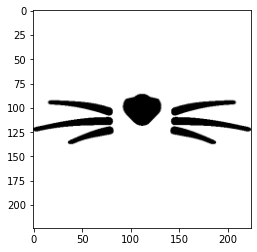

(224, 224, 3)


In [213]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h), interpolation=cv2.INTER_AREA)
plt.imshow(img_sticker)
plt.show()
print(img_sticker.shape)

In [222]:
refined_x = x              # left
refined_y = y - h//2       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (217,78)


- 볼 좌표(x,y)에서 스티커의 박스 크기를 고려해 위치를 설정한다.

In [226]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print(sticker_area.shape)

(224, 224, 3)


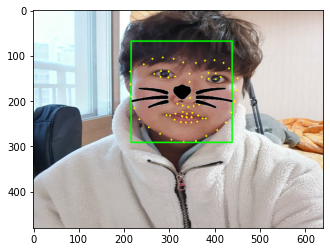

In [216]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

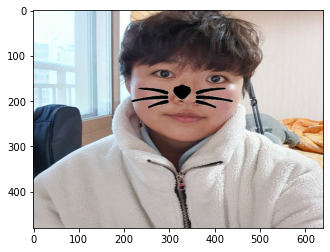

In [228]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- bounding box, landmark를 제거하고 스티커만 입힌 최종 버전
- bounding box가 왼쪽으로 치우쳐져 검출돼 위치가 조금 어긋났지만 코, 볼에 맞는 모습을 볼 수 있다. 

## 5) 밝기, 얼굴각도, 촬영거리가 다른 사진들 테스트
- (1) 밝기가 밝은 사진

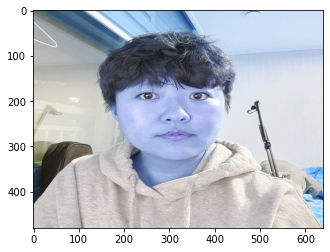

In [230]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/bright.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

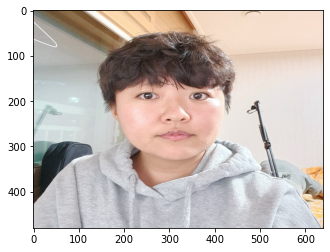

In [235]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [236]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)  # 검출한 얼굴 영역 좌표

rectangles[]
